**The following notebook is to demonstrate how the training of the Clova AI's TPS-ResNet-BiLSTM-CTC model was fine-tuned on Armenian dataset. Please don't execute the cells as they are computationally heavy. Necessary informations are provided throughout the process to understand properly how the fine-tuning was done.**

In [3]:
import sys
import torch
import os
import numpy as np
import pandas as pd
from model import Model
from dataset import LmdbDataset, AlignCollate
from torch.utils.data import DataLoader, random_split

c:\Users\anial\Downloads\capstone-htr\simplehtr38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Adjusting to dataset requirements

The following code helps to convert initial annotations file to a readable format by LMDB

In [ ]:
fixed_lines = []
with open("../SimpleHTR/data/annotations_full.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(" ", 1)
        if len(parts) != 2:
            print(f"Skipping bad line: {repr(line)}")
            continue
        image_path, label = parts
        if image_path.startswith("data/"):
            image_path = image_path[len("data/") :]
        fixed_lines.append(f"{image_path}\t{label}")

with open("../SimpleHTR/data/annotations_full_ocr.txt", "w", encoding="utf-8") as f:
    for line in fixed_lines:
        f.write(line + "\n")

In [8]:
print(len(fixed_lines))

77854


In [ ]:
# custom helper class for setting up the model configuration
class Params:
    pass


opt = Params()
opt.batch_max_length = 32
opt.character = "ԱԲԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքևօֆ՝՝1234567890՝՜:՞«»,.-()"
opt.sensitive = True
opt.imgW = 100
opt.imgH = 32
opt.PAD = True
opt.workers = 0
opt.data_filtering_off = True

## redefining the dataset splits to have train, validation and test 

In [1]:
import random

random.seed(1111)

In [2]:
with open("annotations_full_ocr.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

random.shuffle(lines)

n_total = len(lines)
n_test = int(0.1 * n_total)
n_trainval = n_total - n_test

test_lines = lines[:n_test]
trainval_lines = lines[n_test:]

with open("annotations_trainval_ocr.txt", "w", encoding="utf-8") as f:
    f.writelines(trainval_lines)

with open("annotations_test_ocr.txt", "w", encoding="utf-8") as f:
    f.writelines(test_lines)

### creating the lmdb datasets using the CLI commands below

create_lmdb_dataset.py allocates a fixed amount of memory for creating the data (initially it was 1 TB) so accordingly during creation the file was modified to allocate each one a different amount  

In [ ]:
python create_lmdb_dataset.py --inputPath ../SimpleHTR/data --gtFile annotations_trainval_ocr.txt --outputPath ./lmdb/armenian_trainval

In [ ]:
python create_lmdb_dataset.py --inputPath ../SimpleHTR/data --gtFile annotations_test_ocr.txt --outputPath ./lmdb/armenian_test

In [172]:
from dataset import hierarchical_dataset

opt.batch_size = 100  # Same as SImpleHTR

opt.train_data = "./lmdb/armenian_trainval"
trainval_dataset, _ = hierarchical_dataset(
    root=opt.train_data, opt=opt, select_data=["/"]
)
n_total = len(trainval_dataset)
train_ratio = 8 / 9  # ~88% - 80% of original, same splitting logic as SimpleHTR
n_train = int(train_ratio * n_total)
n_val = n_total - n_train

torch.manual_seed(1111)
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val])

Align = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)

train_loader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.workers,
    collate_fn=Align,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.workers,
    collate_fn=Align,
    pin_memory=True,
)

dataset_root:    ./lmdb/armenian_trainval	 dataset: /
sub-directory:	/.	 num samples: 70069


In [173]:
print(len(train_dataset), len(val_dataset))

62283 7786


# Preparing the Model

## setting up the rest of the params

In [ ]:
# model architecture
opt.num_fiducial = 20
opt.input_channel = 1
opt.rgb = False
opt.output_channel = 512
opt.hidden_size = 256
opt.Transformation = "TPS"
opt.FeatureExtraction = "ResNet"
opt.SequenceModeling = "BiLSTM"
opt.Prediction = "CTC"
opt.num_class = 100

In [175]:
len(opt.character)  # number of output characters (letters + numbers + punctuation)

100

In [176]:
pretrained_path = "./pretrained/TPS-ResNet-BiLSTM-CTC.pth"
state_dict = torch.load(pretrained_path, map_location="cpu")
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        new_key = k[
            7:
        ]  # removeing the word 'module' to successfully load the pretrained model
    else:
        new_key = k
    new_state_dict[new_key] = v

C:\Users\anial\AppData\Local\Temp\ipykernel_20992\3767002448.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location='cpu')

Now, to fine-tune, the last layer of the pretrained model that currently maps to English character set has to be dropped, in order to do that , `Prediction.weight` and `Prediction.bias` have to be dropped and re-initialized by a new linear layer that maps already to Armenian character set with a size of 100.

In [177]:
for layer in ["Prediction.weight", "Prediction.bias"]:
    if layer in new_state_dict:
        del new_state_dict[layer]

model = Model(opt)

In [178]:
model.load_state_dict(new_state_dict, strict=False)  # successfully dropped

_IncompatibleKeys(missing_keys=['Prediction.weight', 'Prediction.bias'], unexpected_keys=[])

In [ ]:
import torch.nn as nn

# manually changing the last layer for Armenian
model.Prediction = nn.Linear(opt.hidden_size, opt.num_class)

In [180]:
print(model)  # Prediction is now defined properly

Model(
  (Transformation): TPS_SpatialTransformerNetwork(
    (LocalizationNetwork): LocalizationNetwork(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): MaxPool2d(kernel_size=2, 

In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Before proceeding, let's find how many trainable parameters there are

In [184]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [185]:
print(f"Total_params: {total_params}, trainable params: {trainable_params}")  # ~ 50M

Total_params: 48874284, trainable params: 48874284


# Training 

In [187]:
import torch.nn.functional as F
import torch.optim as optim
import time

In [ ]:
model = model.to(device)
loss_fn = torch.nn.CTCLoss(zero_infinity=True)
loss_fn = loss_fn.to(device)  # defining the loss function

In [ ]:
optimizer = optim.Adam(
    model.parameters(), lr=0.001
)  # the Adam opimizer with a learning rate of 0.001

In [190]:
n_epochs = 30
best_val_loss = float("inf")
clip_value = 5  # default gradient clipping value

In [ ]:
from utils import CTCLabelConverter

converter = CTCLabelConverter(opt.character)  # initializing the CTC converter

In [ ]:
import editdistance


# creating a small function to evaluate the Character Error Rate on predictions
# this is crucial for the training to be consistent with SimpleHTR training
# the model with the best result of Validation CER is going to be saved
def cer(pred: str, truth: str) -> float:
    if len(truth) == 0:
        return float("inf") if len(pred) > 0 else 0.0
    return editdistance.eval(pred, truth) / len(truth)

In [193]:
best_val_cer = float("inf")

### The Training Loop - took approximately 10.5 hours

In [ ]:
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for idx, (images, labels) in enumerate(train_loader, 1):
        print(f"Processing training batch {idx}/{len(train_loader)}")
        images = images.to(device)

        # label encoding
        text, length = converter.encode(labels, batch_max_length=opt.batch_max_length)
        text = text.to(device)
        length = length.to(device)

        optimizer.zero_grad()

        # forward pass
        preds = model(images, text)

        preds_size = torch.IntTensor([preds.size(1)] * preds.size(0)).to(device)
        preds = preds.log_softmax(2).permute(1, 0, 2)

        loss = loss_fn(preds, text, preds_size, length)

        # backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # evaluating on validation
    model.eval()
    val_loss = 0.0
    val_cer_total = 0.0
    n_samples = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader, 1):
            print(f"Processing validation batch {idx}/{len(val_loader)}")
            images = images.to(device)

            text, length = converter.encode(
                labels, batch_max_length=opt.batch_max_length
            )
            text = text.to(device)
            length = length.to(device)

            preds = model(images, text)

            preds_size = torch.IntTensor([preds.size(1)] * preds.size(0)).to(device)
            preds = preds.log_softmax(2).permute(1, 0, 2)

            loss = loss_fn(preds, text, preds_size, length)
            val_loss += loss.item()

            # decoding the predictions correctly
            _, preds_index = preds.max(2)  # [T, B]
            preds_index = preds_index.transpose(1, 0).contiguous()  # [B, T]
            preds_size = torch.IntTensor([preds_index.size(1)] * preds_index.size(0))
            decoded_preds = converter.decode(preds_index, preds_size)

            decoded_targets = labels

            for pred_str, true_str in zip(decoded_preds, decoded_targets):
                val_cer_total += cer(pred_str, true_str)
                n_samples += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_val_cer = val_cer_total / n_samples
    elapsed = time.time() - start_time

    print(
        f"Epoch [{epoch}/{n_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | CER: {avg_val_cer:.4f} | Time: {elapsed:.1f}s"
    )

    # Saving the best model based on validation set results
    if avg_val_cer < best_val_cer:
        print(f"Saving new best model at epoch {epoch} (CER improved)")
        torch.save(model.state_dict(), f"./saved_models/best_model_epoch_{epoch}.pth")
        best_val_cer = avg_val_cer

Processing training batch 1/623
Processing training batch 2/623
Processing training batch 3/623
Processing training batch 4/623
Processing training batch 5/623
Processing training batch 6/623
Processing training batch 7/623
Processing training batch 8/623
Processing training batch 9/623
Processing training batch 10/623
Processing training batch 11/623
Processing training batch 12/623
Processing training batch 13/623
Processing training batch 14/623
Processing training batch 15/623
Processing training batch 16/623
Processing training batch 17/623
Processing training batch 18/623
Processing training batch 19/623
Processing training batch 20/623
Processing training batch 21/623
Processing training batch 22/623
Processing training batch 23/623
Processing training batch 24/623
Processing training batch 25/623
Processing training batch 26/623
Processing training batch 27/623
Processing training batch 28/623
Processing training batch 29/623
Processing training batch 30/623
Processing training

# Inference

In [196]:
best_model_path = (
    "./saved_models/best_model_epoch_27.pth"  # loading the very last best model
)
best_state_dict = torch.load(best_model_path, map_location="cpu")

C:\Users\anial\AppData\Local\Temp\ipykernel_20992\1915653020.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(best_model_path, map_location='

In [197]:
best_model = Model(opt)
best_model.load_state_dict(best_state_dict, strict=False)  # successfully loaded

<All keys matched successfully>

In [ ]:
concat_dataset = train_loader.dataset.dataset
subset_indices = train_loader.dataset.indices

In [ ]:
lmdb_dataset = concat_dataset.datasets[0]
env = lmdb_dataset.env
n_samples = lmdb_dataset.nSamples

In [ ]:
def evaluate_loader(model, loader, loader_name, converter, opt):
    """Evaluates the data split and returns a Dataframe with the predictions"""
    model.eval()
    results = []
    total_cer = 0.0
    n_samples = 0
    if isinstance(loader.dataset, torch.utils.data.Subset):
        subset_indices = loader.dataset.indices
    else:
        subset_indices = list(range(len(loader.dataset)))

    with torch.no_grad():
        for idx, (images, labels) in enumerate(loader, 1):
            print(f"[{loader_name}] Processing batch {idx}/{len(loader)}")
            images = images.to(device)

            # dummy input for CTC
            text_for_pred = (
                torch.LongTensor(images.size(0), opt.batch_max_length + 1)
                .fill_(0)
                .to(device)
            )

            preds = model(images, text_for_pred)
            preds = preds.log_softmax(2).permute(1, 0, 2)

            _, preds_index = preds.max(2)
            preds_index = preds_index.transpose(1, 0).contiguous()
            preds_size = torch.IntTensor([preds_index.size(1)] * preds_index.size(0))
            decoded_preds = converter.decode(preds_index, preds_size)

            for i, (pred_str, true_str) in enumerate(zip(decoded_preds, labels)):
                sample_index = subset_indices[n_samples] + 1  # LMDB is 1-based
                cer_val = cer(pred_str, true_str)
                total_cer += cer_val
                correct = pred_str == true_str
                results.append(
                    {
                        "set": loader_name,
                        "index": sample_index,
                        "prediction": pred_str,
                        "ground_truth": true_str,
                        "correct": correct,
                    }
                )
                n_samples += 1

    avg_cer = total_cer / n_samples
    print(
        f"[{loader_name.upper()}] Avg CER: {avg_cer:.4f} — Total Samples: {n_samples}"
    )
    return results

In [214]:
best_model = best_model.to(device)

In [215]:
train_results = evaluate_loader(best_model, train_loader, "train", converter, opt)
val_results = evaluate_loader(best_model, val_loader, "val", converter, opt)

[train] Processing batch 1/623
[train] Processing batch 2/623
[train] Processing batch 3/623
[train] Processing batch 4/623
[train] Processing batch 5/623
[train] Processing batch 6/623
[train] Processing batch 7/623
[train] Processing batch 8/623
[train] Processing batch 9/623
[train] Processing batch 10/623
[train] Processing batch 11/623
[train] Processing batch 12/623
[train] Processing batch 13/623
[train] Processing batch 14/623
[train] Processing batch 15/623
[train] Processing batch 16/623
[train] Processing batch 17/623
[train] Processing batch 18/623
[train] Processing batch 19/623
[train] Processing batch 20/623
[train] Processing batch 21/623
[train] Processing batch 22/623
[train] Processing batch 23/623
[train] Processing batch 24/623
[train] Processing batch 25/623
[train] Processing batch 26/623
[train] Processing batch 27/623
[train] Processing batch 28/623
[train] Processing batch 29/623
[train] Processing batch 30/623
[train] Processing batch 31/623
[train] Processin

from the above exectutions it can be seen that the CER for the train set was ~ 0.2% and for the validation set it was ~ 1.2%

In [ ]:
df_train = pd.DataFrame(train_results)
df_val = pd.DataFrame(val_results)
# saving the results
df_train.to_csv("./results/train_inference_results.csv", index=False)
df_val.to_csv("./results/val_inference_results.csv", index=False)

### Word Accuracy Rates (WAR)

In [221]:
len(df_train[df_train["correct"] == True]) / len(df_train)  # train WAR ~ 98.1%

0.9812629449448486

In [222]:
len(df_val[df_val["correct"] == True]) / len(df_val)  # validation WAR ~ 91.4%

0.9139481119958901

### evaluating on test set

In [223]:
opt.test_data = "./lmdb/armenian_test"
test_dataset, _ = hierarchical_dataset(root=opt.test_data, opt=opt, select_data=["/"])
test_loader = DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.workers,
    collate_fn=Align,
    pin_memory=True,
)

dataset_root:    ./lmdb/armenian_test	 dataset: /
sub-directory:	/.	 num samples: 7785


In [226]:
test_results = evaluate_loader(best_model, test_loader, "test", converter, opt)

[test] Processing batch 1/78
[test] Processing batch 2/78
[test] Processing batch 3/78
[test] Processing batch 4/78
[test] Processing batch 5/78
[test] Processing batch 6/78
[test] Processing batch 7/78
[test] Processing batch 8/78
[test] Processing batch 9/78
[test] Processing batch 10/78
[test] Processing batch 11/78
[test] Processing batch 12/78
[test] Processing batch 13/78
[test] Processing batch 14/78
[test] Processing batch 15/78
[test] Processing batch 16/78
[test] Processing batch 17/78
[test] Processing batch 18/78
[test] Processing batch 19/78
[test] Processing batch 20/78
[test] Processing batch 21/78
[test] Processing batch 22/78
[test] Processing batch 23/78
[test] Processing batch 24/78
[test] Processing batch 25/78
[test] Processing batch 26/78
[test] Processing batch 27/78
[test] Processing batch 28/78
[test] Processing batch 29/78
[test] Processing batch 30/78
[test] Processing batch 31/78
[test] Processing batch 32/78
[test] Processing batch 33/78
[test] Processing b

the above code output shows that the CER on the test set was ~ 1.28% and the below code output shows that the WAR was ~ 90.5%

In [227]:
df_test = pd.DataFrame(test_results)
df_test.to_csv("./results/test_inference_results.csv", index=False)
len(df_test[df_test["correct"] == True]) / len(df_test)  # test WAR ~ 90.5%

0.9049454078355812

In [228]:
df_test[df_test["correct"] == False].head(20)  # A few examples of wrong predictions

,set,index,prediction,ground_truth,correct
5,test,6,Ուորբերոնը,Ուորբեթոնը,False
37,test,38,գղոխազդեցությա,փոխազդեցության,False
38,test,39,Ինլեգտ,Ինլետ,False
57,test,58,Քանոյանին,Ջանոյանին,False
73,test,74,յօժարաթիուն,յօժարութիուն,False
80,test,81,Զաստելիի,Զաստելլիի,False
89,test,90,լարված,շարված,False
103,test,104,Պասևդոմոնադները,Պսևդոմոնադները,False
110,test,111,բաժանվեյին,բաժանվեցին,False
115,test,116,ծածուցիկության,Մածուցիկության,False


# Simple Analysis of the Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import lmdb
import numpy as np
from PIL import Image
import io

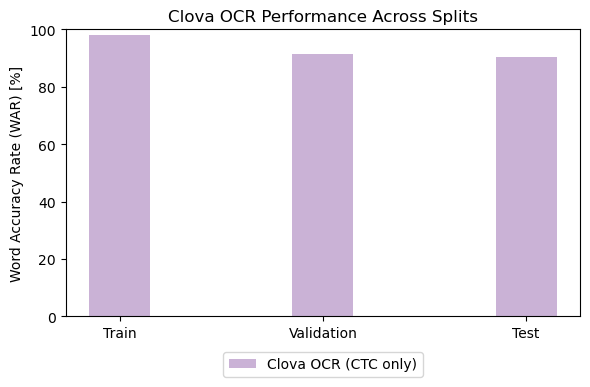

In [229]:
war = {
    "Clova OCR (CTC only)": [
        df_train["correct"].mean() * 100,
        df_val["correct"].mean() * 100,
        df_test["correct"].mean() * 100,
    ]
}

labels = ["Train", "Validation", "Test"]
x = range(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    x,
    war["Clova OCR (CTC only)"],
    width=width,
    label="Clova OCR (CTC only)",
    color="#cab2d6",
)

ax.set_ylabel("Word Accuracy Rate (WAR) [%]")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.set_title("Clova OCR Performance Across Splits")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
def show_lmdb_incorrect(
    df_results, dataset, lmdb_env, max_samples=20, title="Incorrect Predictions"
):
    """Visualizes a few wrong predictions with ground truth and prediction annotations"""

    incorrect = df_results[df_results["correct"] == False].iloc[15 : max_samples + 15]

    fig, axes = plt.subplots(4, 5, figsize=(13, 7))
    fig.suptitle(title, fontsize=16)

    with lmdb_env.begin(write=False) as txn:
        for ax, (_, row) in zip(axes.flat, incorrect.iterrows()):
            idx = row["index"]  # LMDB index (1-based)
            key = f"image-{idx:09d}".encode()
            img_bin = txn.get(key)
            img = Image.open(io.BytesIO(img_bin)).convert("L")  # grayscale

            ax.imshow(np.array(img), cmap="gray")
            ax.set_title(
                f"GT: {row['ground_truth']}\nPred: {row['prediction']}", fontsize=8
            )
            ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

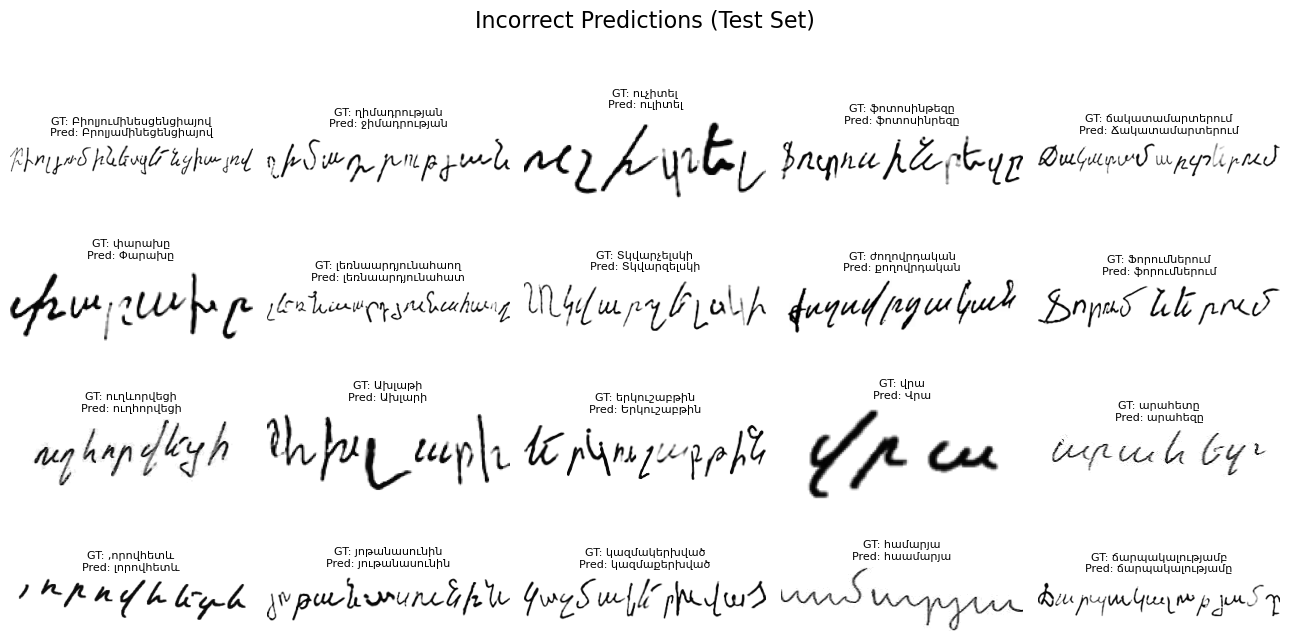

In [ ]:
lmdb_env = lmdb.open("./lmdb/armenian_test", readonly=True, lock=False, readahead=False)
show_lmdb_incorrect(
    df_test,
    test_loader.dataset,
    lmdb_env,
    max_samples=20,
    title="Incorrect Predictions (Test Set)",
)